# TIME SERIES ANALYSIS
#### MSDS 7333 - Quantifying the World 
#### Author:  Mridul Jain, Corey Mathews and Eyob Gebremariam

### Abstract 

This assignment focuses on an indepth time series analysis of a stock market and forcasting using ARIMA model.We will aslo perform backtesting on the given finacial protfolio using Signal frontier Analysis to analyse the lookback time and find the optimal holding that gave the best return.
Time Series (TS) is a series of time stamped data points which are often dependent with each other that gives rise to trends and seasonalities.

##### Keywords:
Time Series, Signal Frontier Analysis, Dickey-Fuller test, ARIMA, AR, MA, Stationary, Seasonality  


# Introduction

Timeseries analysis is one of the most important subjects of data analysis. Many devices, systems, sensors and networks usually generate some form of data which is very correlated to itself but offset in time. The main goal of this analysis is to identify patterns in the sequence of numbers which are related to themselves, but offset in time. Another goal in many research applications is to test the impact of some treatment or interventions to this serially correlated data. Time series analysis is also used to predict the future outcomes, patterns, demands, forecast and compare series with different kind of events for example external factors.

In this case study, we are analyzing the stock price trends for some of the top stocks and trying to analyse the trend and trying to predict the future pattern of these stocks.

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from dateutil.parser import parse
from collections import defaultdict
import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [108]:
stock_price = pd.read_csv('C:\Users\Eyob\Desktop\stock_px2.csv', parse_dates=True, index_col='Date')
stock_price.index

DatetimeIndex(['1990-02-01', '1990-02-02', '1990-02-05', '1990-02-06',
               '1990-02-07', '1990-02-08', '1990-02-09', '1990-02-12',
               '1990-02-13', '1990-02-14',
               ...
               '2011-10-03', '2011-10-04', '2011-10-05', '2011-10-06',
               '2011-10-07', '2011-10-10', '2011-10-11', '2011-10-12',
               '2011-10-13', '2011-10-14'],
              dtype='datetime64[ns]', name=u'Date', length=5472, freq=None)

# Background

Data consists of the daily stock price and volume of some of the top stocks in US financial markets and an Index (SPX) from Yahoo Finance. The tickers of the stoks we have in the dataset are:
Stocks : AA, AAPL, GE, IBM, JNJ, MSFT, PEP, XOM
Index: SPX

Analyzing and predicting the stock prices has been tried for many years with various mathematical models and techniques. Even though its almost impossible to predict the stock prices in advance, but there have been variuos indicators which can guide the investors in the right direction and help maximize the returns in some cases. We do not believe that this analysis can be used to predict or used for making investment decisions. 

Our analysis methodology is divided into three steps:
1. Exploratory Data Analysis - Where we explore the data on high level and infer the trends or other patterns visually
2. Analysis - In this we try to Identify, estimate and diagnose the patterns in the data and build the models as needed. In this section the fist step is identification, in which autocorrelation functions (ACF's) and partial autocorrelation functions (PACF's) are examined to see which of the potential patterns are present in the data i.e. trends over time (Linear, Quadratic or something more complicated), lingering effects of earlier scores or lingering effects of earlier shocks. 
3. Diagnosing the model and explaining results

#### Exploratory Data Analysis

In [6]:
# Create stock daily volume dataframe for each stock.
stock_vol = pd.read_csv('C:\Users\Eyob\Desktop\Volume.csv', parse_dates=True, index_col='Date')
stock_price.index
print (stock_vol.head())
print (stock_vol.tail())
print (stock_vol.shape)

                 AA      AAPL        GE       IBM      JNJ       MSFT  \
Date                                                                    
1990-02-01  2185600   4193200  14457600   6903600  5942400   89193600   
1990-02-02  3103200   4248800  15302400   6064400  4732800   71395200   
1990-02-05  1792800   3653200   9134400   5299200  3950400   59731200   
1990-02-06  2205600   2640000  14389200  10808000  3761600   81964800   
1990-02-07  3592800  11180800  18704400  12057600  5458400  134150400   

                  PEP        SPX      XOM  
Date                                       
1990-02-01  2954400.0  154580000  2916400  
1990-02-02  2424000.0  164400000  4250000  
1990-02-05  2225400.0  130950000  5880800  
1990-02-06  3270000.0  134070000  4750800  
1990-02-07  4332600.0  186710000  4124800  
                   AA      AAPL        GE      IBM      JNJ      MSFT  \
Date                                                                    
2011-10-10   29555500  15769200  5

In [73]:
stock_vol = stock_vol[stock_vol.index > datetime(2006, 1,1)]
stock_vol.shape

(1458, 9)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2006-01-03 to 2011-10-14
Data columns (total 9 columns):
AA      1458 non-null float64
AAPL    1458 non-null float64
GE      1458 non-null float64
IBM     1458 non-null float64
JNJ     1458 non-null float64
MSFT    1458 non-null float64
PEP     1458 non-null float64
SPX     1458 non-null float64
XOM     1458 non-null float64
dtypes: float64(9)
memory usage: 113.9 KB


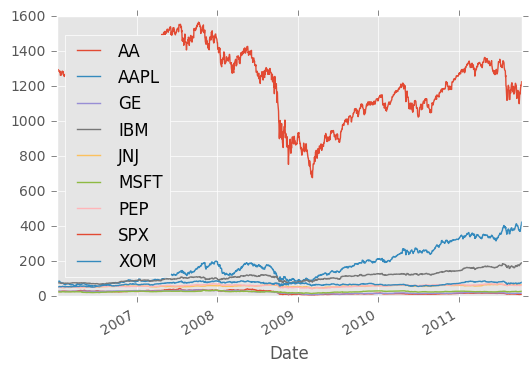

In [74]:
# Plot the last 5 years of closing stock prices
stock_price.info()
stock_price.plot()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1458 entries, 2006-01-03 to 2011-10-14
Data columns (total 9 columns):
AA      1458 non-null int64
AAPL    1458 non-null int64
GE      1458 non-null int64
IBM     1458 non-null int64
JNJ     1458 non-null int64
MSFT    1458 non-null int64
PEP     1458 non-null float64
SPX     1458 non-null int64
XOM     1458 non-null int64
dtypes: float64(1), int64(8)
memory usage: 113.9 KB


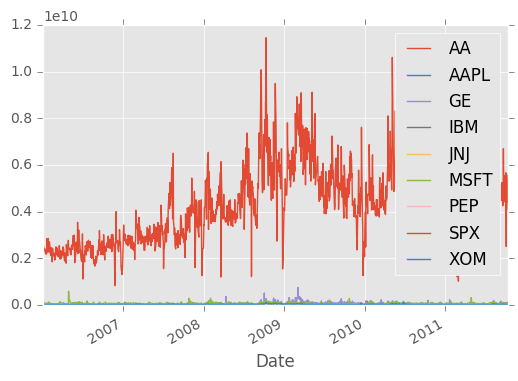

In [75]:
# Plot 5 years of volume transactions
stock_vol.info()
stock_vol.plot()

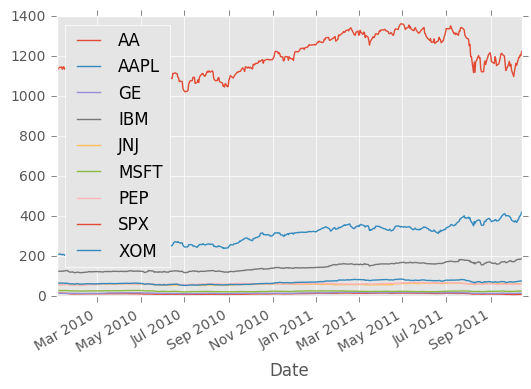

In [76]:
# Plot stock closing prices for the years 2010 and 2011
stock_price.ix['2010':'2011'].plot()

#### Time Series Analysis
There are various ways suggested in texts for analyzing the time-series data. For example, smoothing methods are using extrapolation based on moving averages with some adjustments for trends and seasonality. Decomposition methods also used these techniques to further break down the series and prepare for forecasting. The Box-Jenkins (ARMA or ARIMA) method where series differencing is used to stationarize the time series data and then combine Autoregressive and Moving averages to yield comprehensive model for forecasting and prediction.

We will explore data for mean, variance,trend and seasonality and finally use smothing techniques such as moving average and exponetial. Finally the Dicky-Fuller test will be utilized to determine if the series is stationary.

#### Assumptions of timeseries analysis
The usual assumptions apply with regards to causal inference of timeseries analysis. In order to analyse and understand the timeseries better all the sequestial contingencies should be removed i.e. residuals are reflection of random shocks, independent and normally distributed with zero mean and homogeneity of variance (McCleary and Hay 1980). In the case of non constant variance, its suggested to apply some form of transformation to the original data before building the model.
Timeseries data inherently violates the assumption of independence of residuals because of autocorrelations over time. Hence, during the diagnosis phase, once our model is developed and residuals are computed, there should be no autocorrelations and partial autocorrelations at various lags. If there are remaining autocorrelations at various lags, this indicates other possible patterns and must be treated and carefully analyzed.

In our case, since we will be using Box-Jenkins method for the analysis, its important to note that the Box–Jenkins method requires that the discrete time series data be equally spaced over time and that there be no missing values in the series.

#### Stationarity
A TS is stationary when the folowing criteria are met:
* constant mean
* constant variance
* autocovariance doesn not depend on time

We are going to experiment with only Apple(AAPL) stock and a time range of 5 years (2006-2011) where the stock price has picked up well.

#### Dickey-Fuller Test
There are objective tests that may be conducted to determine whether a series is nonstationary. The series could be nonstationary because of random walk, drift, or trend. (Ref: An Introduction to Time Series Analysis and Forecasting with Applications of SAS and SPSS). To test the non-stationarity in the series, Augmented Dickey fuller test is used.

Dickey–Fuller test tests the null hypothesis of whether a unit root is present in an autoregressive model. Dickey-Fuller test is used to test the three model contexts 
(1) a pure random walk
(2) random walk plus drift
(3) the combination of deterministic trend, random walk, and drift. 

The following is Dicky-Fuller test method in Python. It is a test of null-hypothesis, where the null hypothesis is that the data is non-stationary. If the test statistic is less than the critical value, we can reject the null hypothesis and say that the series is stationary.  

In [136]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=22)
    rolstd = pd.rolling_std(timeseries, window=22)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

(1458L,)


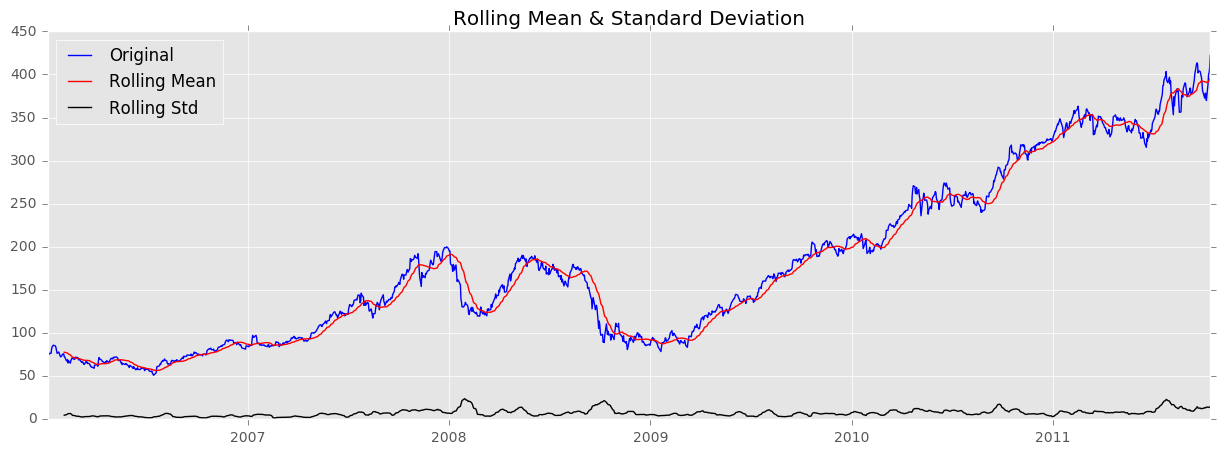

Results of Dickey-Fuller Test:
Test Statistic                    0.748005
p-value                           0.990749
#Lags Used                        4.000000
Number of Observations Used    1453.000000
Critical Value (5%)              -2.863531
Critical Value (1%)              -3.434859
Critical Value (10%)             -2.567830
dtype: float64


In [137]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple = pd.Series(stock_price.AAPL['2006':'2011'])
print (Apple.shape)
test_stationarity(Apple)

There is a clear up and down trend in the data without any visible seasonal trend.The Dickey-Fuller null hypothesis is that the time series is non-stationary. The alternative hypothesis is that the time series is stationary. If Dickey-Fuller test probability is greater or equal to .05(significant value), then we do not have sufficient evidence to reject the null hypothesis. As the result shows, at 95% confidence our P-value >0.05 therefore we fail to reject null hypothesis. Apples stock is non-stationary and we will use different transformation techniques to convert it to stationary data.

Since we have a p-value of 0.884249 with 95% confidence level, this is not a stationary series. The variation in standard deviation is negligible. 

### Converting  stationary condition.

This is achieved by eliminating seasoanlity and trending

* Trend causes variation of means over time 
* seasonality alslo causes variations.But it is different from a linear or quadratic data trend in that it is predictably spaced in time

Naturally in order to be able to perform statistical prediction, we need to eliminate these 2 major factors.

##### Transforming the data to eliminate the non-constant variance
Log transformation is the common way of eliminating variance as it punishes higher variance and as it can be seen in the following analysis the log transformation has eliminated the non constant variance where as the subtraction of the rolling mean has given as a constant mean. Hence our Dickey Fuller test shows that we have suffiecient evidence that our serious is stationary.

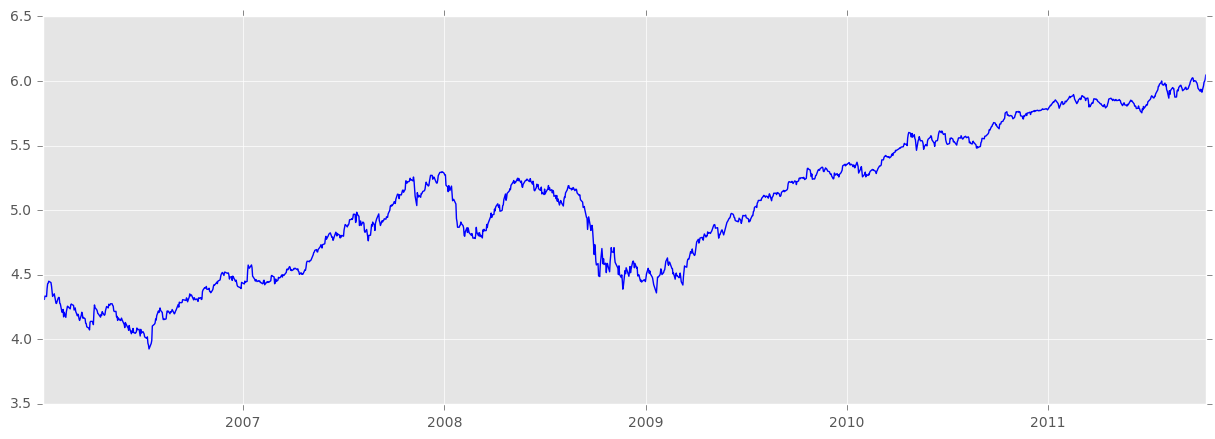

In [138]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple_log = np.log(Apple)
plt.plot(Apple_log, color='b')

#### Smoothing 

Naturally data collected in a series of time tend to show random variation. Smoothing is a method of reducing or canceling the effect due to random variation.

##### Moving Average
Moving average is one of the common ways of smoothing the series. We will use 2 weeks (10) business days to find the rolling mean i.e we are giving equal weight to the last 10 observations and finding the mean. This will give missing values for the first 9 observations as the rolling mean can not be calculated

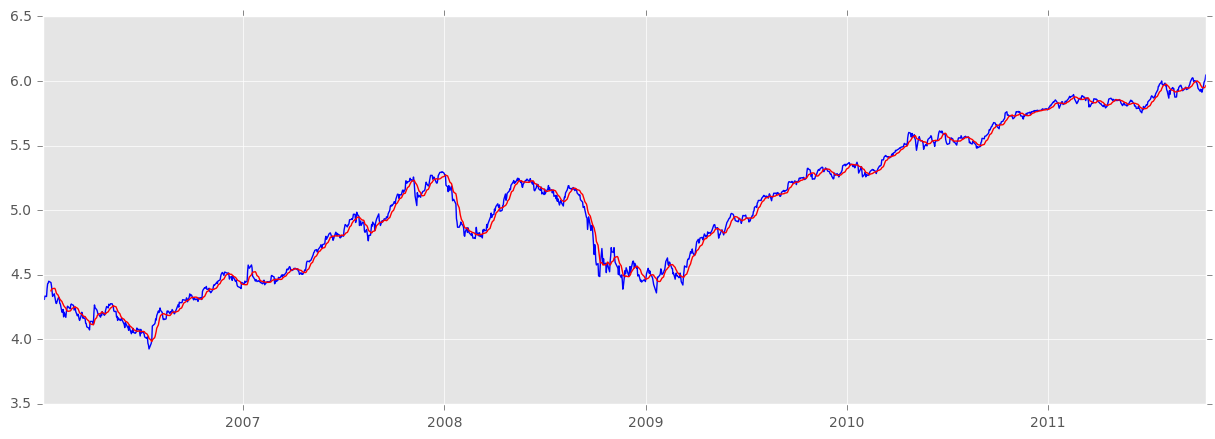

In [139]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
moving_avg = pd.rolling_mean(Apple_log, 10)
plt.plot(Apple_log, color='b')
plt.plot(moving_avg, color='r')

The red plot shows the result of "smoothing" process of the data. On the following Series, notice that the first 14 observations are "NaN", since we need the first 14 values in order to calculate the first moving average value.   

In [140]:
Apple_moving_avg_diff = Apple_log - moving_avg
Apple_moving_avg_diff.head(18)

Date
2006-01-03         NaN
2006-01-04         NaN
2006-01-05         NaN
2006-01-06         NaN
2006-01-09         NaN
2006-01-10         NaN
2006-01-11         NaN
2006-01-12         NaN
2006-01-13         NaN
2006-01-17    0.064044
2006-01-18    0.027634
2006-01-19   -0.020375
2006-01-20   -0.060685
2006-01-23   -0.041913
2006-01-24   -0.063109
2006-01-25   -0.079009
2006-01-26   -0.089696
2006-01-27   -0.078134
Name: AAPL, dtype: float64

We then drop all "NaN" observations and run Dickey-Fuller stationary test.

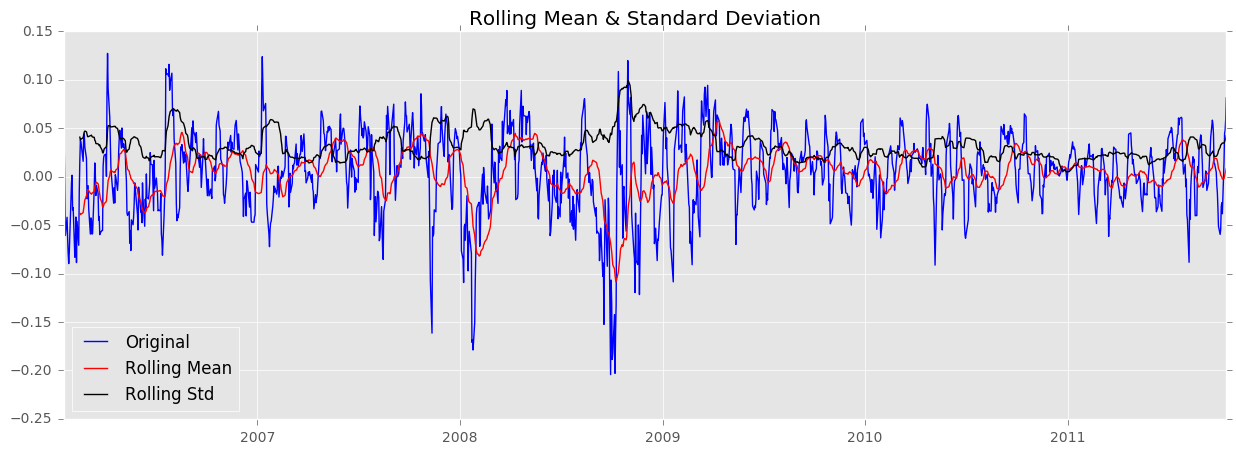

Results of Dickey-Fuller Test:
Test Statistic                -8.608486e+00
p-value                        6.573057e-14
#Lags Used                     9.000000e+00
Number of Observations Used    1.439000e+03
Critical Value (5%)           -2.863551e+00
Critical Value (1%)           -3.434902e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


In [141]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple_moving_avg_diff.dropna(inplace=True)
test_stationarity(Apple_moving_avg_diff)

At 95% confidence level ( p-value < 0.05) and the T statistics is lower than the critical value. Therefore we have sufficent evidence to reject the null hypothesis that the time series data is not staionary and conclude that the series is now stationary. Moving average were able to change series to stationary condition.  

### Expoential decay smoothing

As opposed to moving average, older data is given a relatively decaying weight (importance) whereas newer data is given greater weight (importance). This technique is also employed in making short-term forecasts.

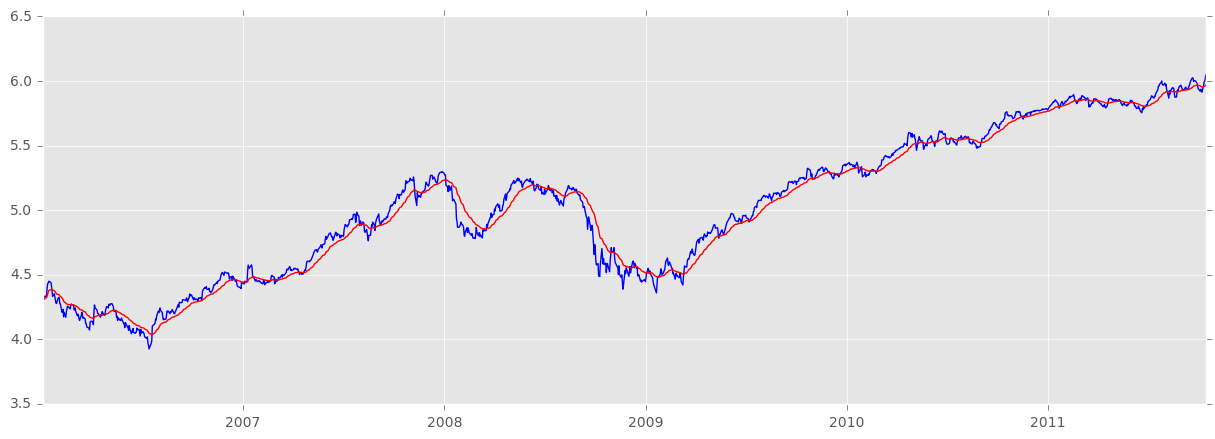

In [142]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
expwighted_avg = pd.ewma(Apple_log, halflife=10)
plt.plot(Apple_log, color='b')
plt.plot(expwighted_avg, color='r')

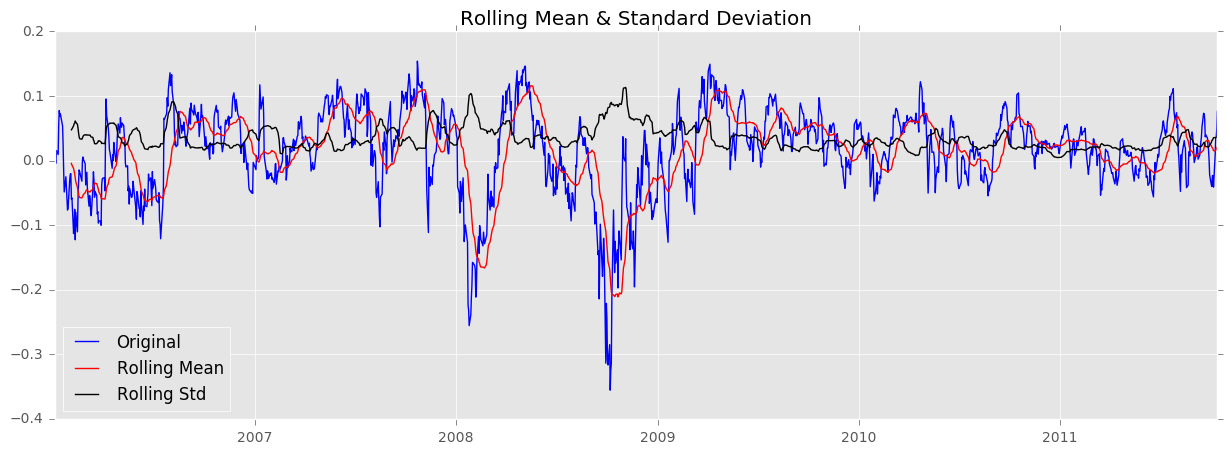

Results of Dickey-Fuller Test:
Test Statistic                -6.007312e+00
p-value                        1.604040e-07
#Lags Used                     6.000000e+00
Number of Observations Used    1.451000e+03
Critical Value (5%)           -2.863534e+00
Critical Value (1%)           -3.434865e+00
Critical Value (10%)          -2.567832e+00
dtype: float64


In [143]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple_log_ewma_diff = Apple_log - expwighted_avg
test_stationarity(Apple_log_ewma_diff)

At 95% confidence level ( p-value < 0.05) and the T statistics is lower than the critical value. Therefore we have sufficent evidence to reject the null hypothesis that the time series data is not staionary and conclude that the series is now stationary. Moving average were able to change series to stationary condition.  The exponential smoothing has also converted the data to stationary

### Handling Seasonality using  Differencing and Decomposition.

Where Seasonality i.e variation in a specific time period is significantly high, deterending techniques such as subtrcating the average fails to eliminate seasonality. When faced with such situation we remove seaonality by the following methods

* Differencing – taking the differece with a particular time lag
* Decomposition – modeling both trend and seasonality and removing them from the model

##### Differencing
Log return is  taking the differece with a particular time lag by which trend as well as seaonality of series is removed. Here we perform a first order differencing hence the first value of the series will have no value.

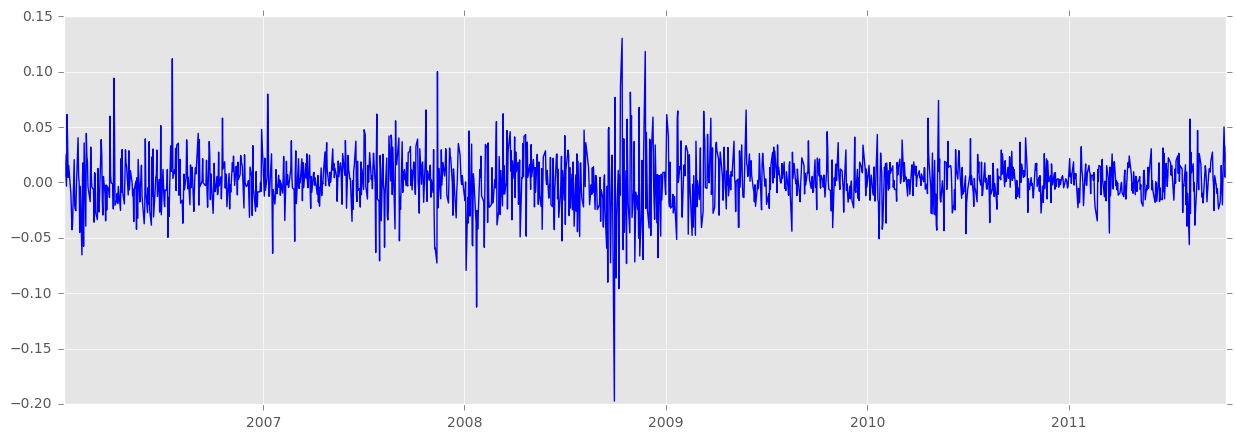

In [144]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple_log_diff = Apple_log - Apple_log.shift()
plt.plot(Apple_log_diff, color='b')

In [145]:
Apple_log_diff.head(5)

Date
2006-01-03         NaN
2006-01-04    0.002939
2006-01-05   -0.007901
2006-01-06    0.025486
2006-01-09   -0.003282
Name: AAPL, dtype: float64

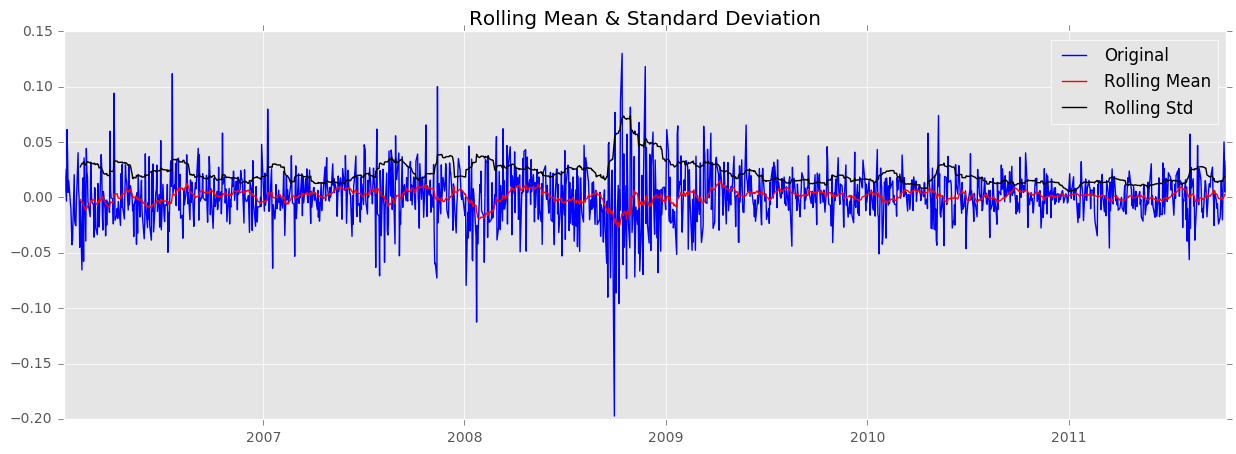

Results of Dickey-Fuller Test:
Test Statistic                -1.554921e+01
p-value                        2.110616e-28
#Lags Used                     5.000000e+00
Number of Observations Used    1.451000e+03
Critical Value (5%)           -2.863534e+00
Critical Value (1%)           -3.434865e+00
Critical Value (10%)          -2.567832e+00
dtype: float64


In [146]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple_log_diff.dropna(inplace=True)
test_stationarity(Apple_log_diff)

At 95% confidence level ( p-value < 0.05) and the T statistics is lower than the critical value. Therefore we have sufficent evidence to reject the null hypothesis that the time series data is not staionary and conclude that the series is now stationary. Moving average were able to change series to stationary condition. The log return has effectively converted the data to stationary

### Decomposition
In this technique, both trend and seasonality are modeled separately and the remaining part of the series is returned.

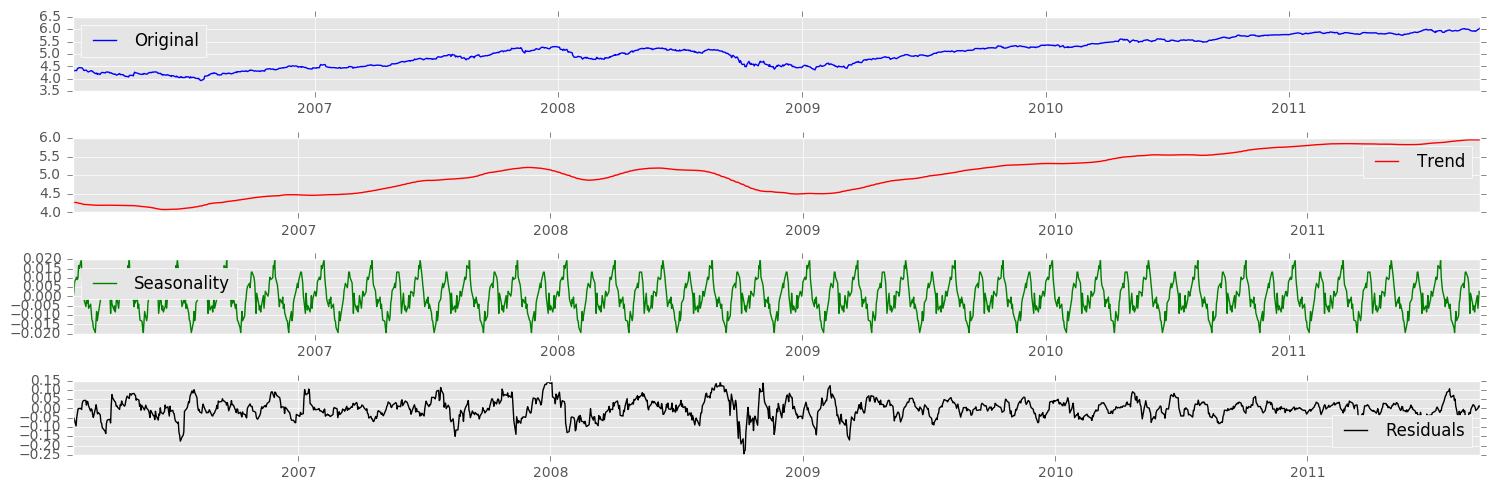

In [147]:
# Create a DataFrame with Series
df = pd.DataFrame(Apple_log)

# Get the time index from Series
idx = pd.DatetimeIndex(Apple_log.index)
df.set_index(idx, inplace=True)

# Resample using weekday frequency
df2 = df.resample('B').mean()

# Fill in missing values with interpolate
df2.AAPL.interpolate(inplace=True)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2.AAPL)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(411)
plt.plot(Apple_log, label='Original', color='b')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='r')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='g')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='k')
plt.legend(loc='best')
plt.tight_layout()


We now can run stationary test on the residuals

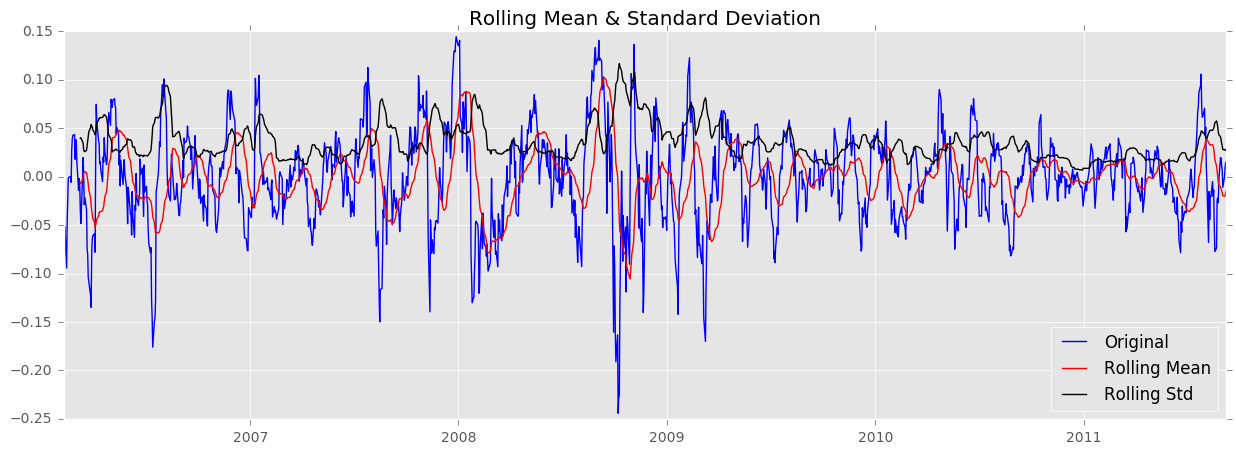

Results of Dickey-Fuller Test:
Test Statistic                -1.027189e+01
p-value                        3.981604e-18
#Lags Used                     1.600000e+01
Number of Observations Used    1.440000e+03
Critical Value (5%)           -2.863549e+00
Critical Value (1%)           -3.434899e+00
Critical Value (10%)          -2.567840e+00
dtype: float64


In [148]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
Apple_log_decompose = residual
Apple_log_decompose.dropna(inplace=True)
test_stationarity(Apple_log_decompose)

At 95% confidence level ( p-value < 0.05) and the T statistics is lower than the critical value. Therefore we have sufficent evidence to reject the null hypothesis that the time series data is not staionary and conclude that the series is now stationary. Moving average were able to change series to stationary condition. Decomposition has effectively converted the data to stationary as well.

### Forecasting using ARIMA (Autoregressive Integrated Moving Average) 

As mentioned and explained previously, the Box-Jenkins (ARIMA) method is very robust and useful method for forecasting and hence the model developed with this approach serve not only to explain the underlying process generating the series, but as a basis for forecasting.

The Autocorrelation Function (ACF) and Partial Autocorrelation Function(PACF) can be used to determine the value of AR and MA

In [149]:
from statsmodels.tsa.stattools import acf, pacf

In [150]:
# Show 10 days for the plot
lag_acf = acf(Apple_log_diff, nlags=15)
lag_pacf = pacf(Apple_log_diff, nlags=15)

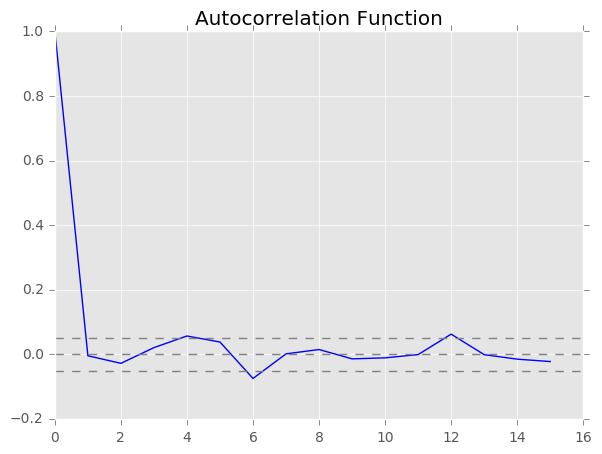

In [151]:
#Plot ACF:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(121) 
plt.plot(lag_acf, color='b')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Apple_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Apple_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

Autocorrelation is a correlation coefficient between two values of the same variable at times Xi and Xi+k. The ACF represents the degree of persistence of auto-correlation over respective lags of a variable
The lag value of ACF is where it crosses the limits which is around day 3. 

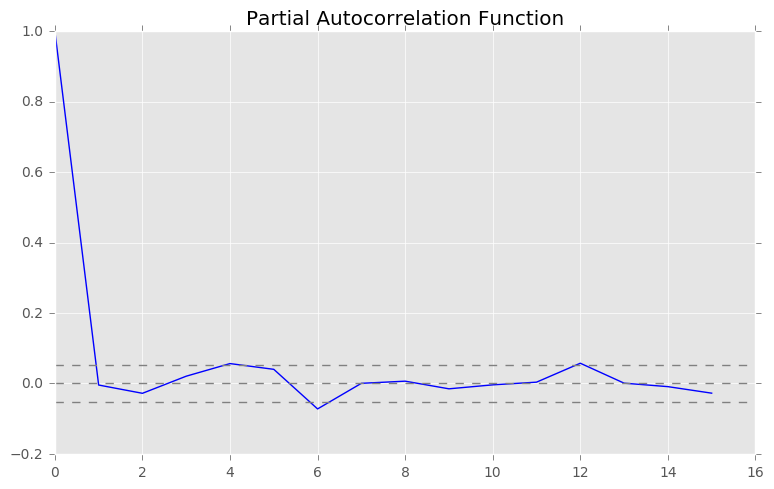

In [152]:
#Plot PACF:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(122)
plt.plot(lag_pacf, color='b')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(Apple_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(Apple_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Partial correlation measures the degree of association between two random variables, with the effect of a set of controlling random variables removed.
For PACF, the lag value is also shown at around 3 day.

##### AR Model

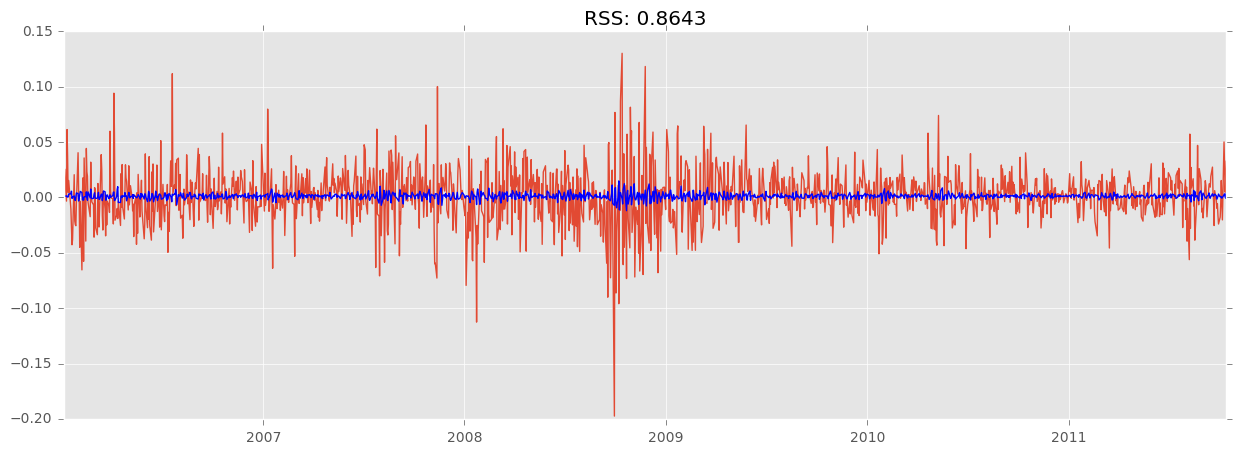

In [153]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
model = sm.tsa.ARIMA(Apple_log, order=(6, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(Apple_log_diff)
plt.plot(results_AR.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-Apple_log_diff)**2))

In the above model, we passed tuple value of (1, 1, 0) to reflect ACF lag value of 1, differencing order of 1 and disregard PACF.

##### MA Model

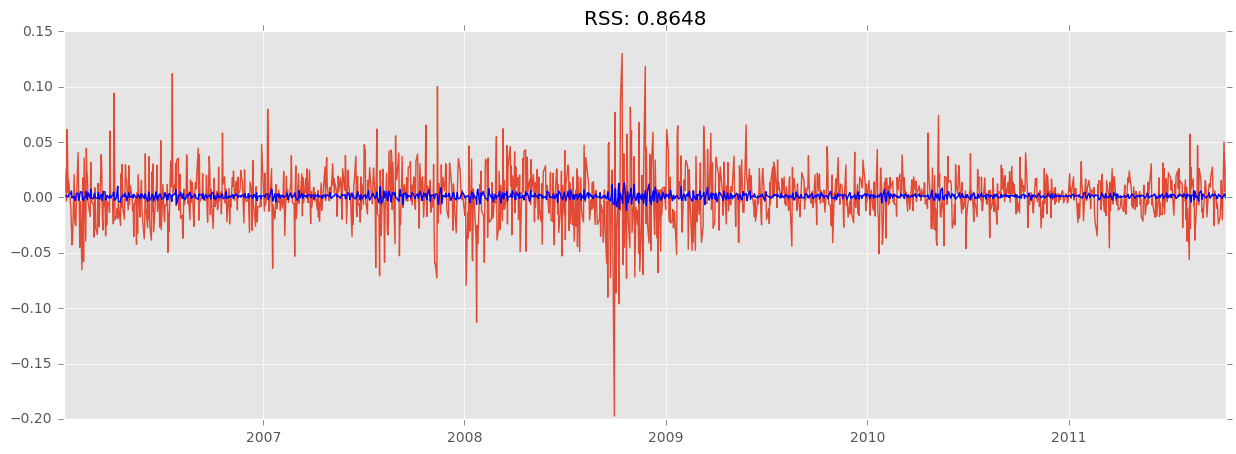

In [154]:
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
model = sm.tsa.ARIMA(Apple_log, order=(0, 1, 6))  
results_MA = model.fit(disp=-1)  
plt.plot(Apple_log_diff)
plt.plot(results_MA.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-Apple_log_diff)**2))

In the MA model, we passed tuple value of (0, 1, 5) to reflect PACF lag value of 5, differencing order of 1 and disregard ACF.

##### ARIMA Model (Combination)

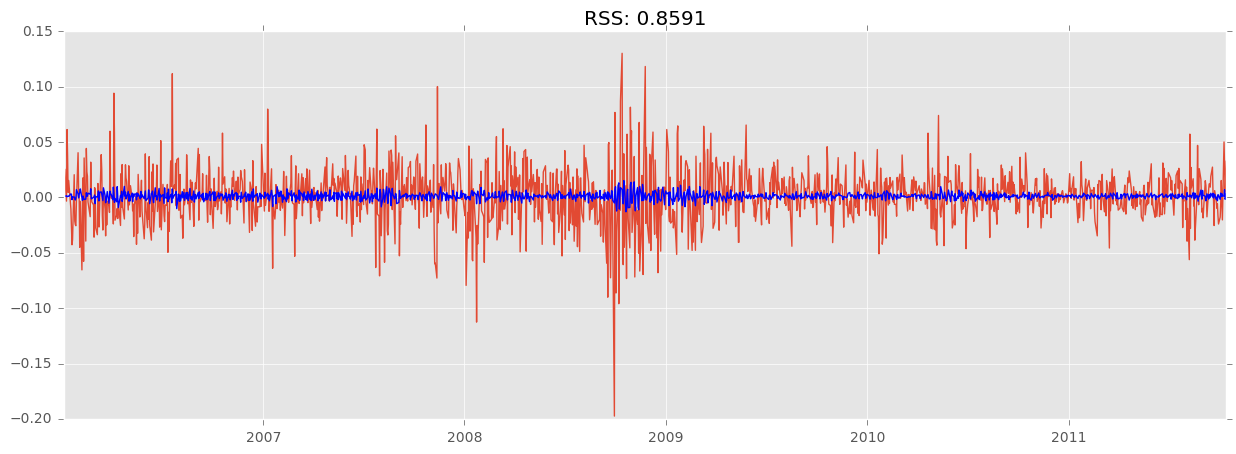

In [155]:
# from statsmodels.tsa.arima_model import ARIMA
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
model =ARIMA(Apple_log, order=(6, 1, 6))
results_ARIMA = model.fit(disp=-1)  
plt.plot(Apple_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-Apple_log_diff)**2))

First, we store the predicted result from ARIMA separately and observe it. 

In [156]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.head()

Date
2006-01-04    0.001175
2006-01-05    0.001177
2006-01-06    0.001115
2006-01-09    0.001469
2006-01-10    0.000594
dtype: float64


In [157]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.head()

Date
2006-01-04    0.001175
2006-01-05    0.002352
2006-01-06    0.003466
2006-01-09    0.004935
2006-01-10    0.005529
dtype: float64


Next, we add to them to base log number.  

In [158]:
predictions_ARIMA_log = pd.Series(Apple_log.ix[0], index=Apple_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

Date
2006-01-03    4.314149
2006-01-04    4.315324
2006-01-05    4.316501
2006-01-06    4.317615
2006-01-09    4.319084
dtype: float64

Finally, we convert back the value from log by taking the exponenent.  We are also showing the comparison of the transformed TS data with the original values. 

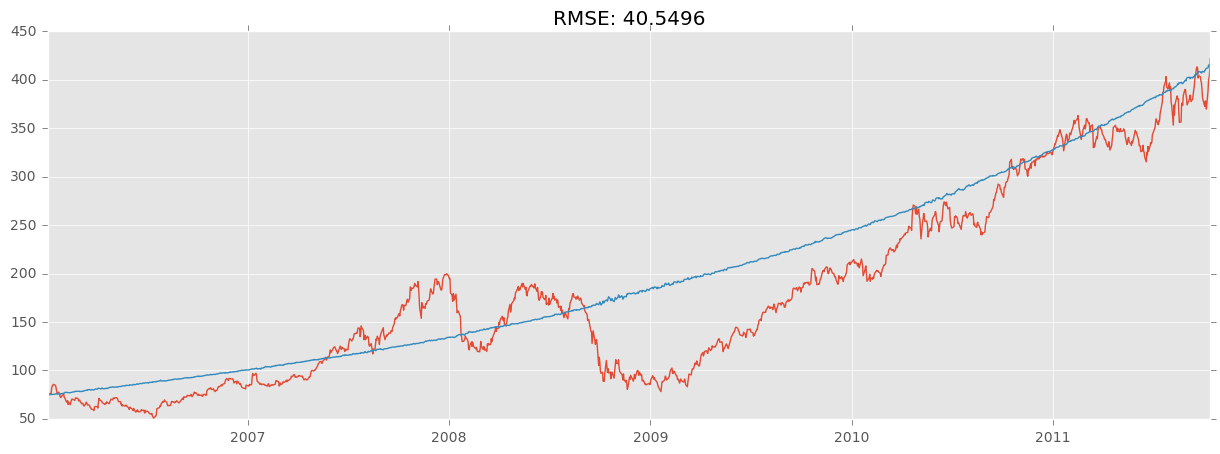

In [159]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.plot(Apple)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-Apple)**2)/len(Apple)))

The Forecast in the original scale follows the trend for most part. However for the year 2008 & 2009 where the trend changes drastically the model fails to follow the trend .The ARIMA models are good short-term forecasting models as it assumes that the underlying factors that resulted such trend will behave in the future in much the same way as in the past. This drawback limits simple ARIMA models from a good long term forecating model. However the univariate ARIMA model can incorporate other factors that affects the stock value by integrating what are called transfer function (or dynamic regression) models. Even though these functions are beyond the scope of this case study, it needs to be explored further to make our forecasting with ARIMA more robust to changes in the underlying trend.

### Signal Frontier Analysis
Cumulative returns for AA,AAPL,GE,IBM,JNJ,MSFTand XOM stocks for the year period of 2006 tp 2011 are ploted against the cumulative return of SPX that tracks the S&P 500 index plotted in black in black.

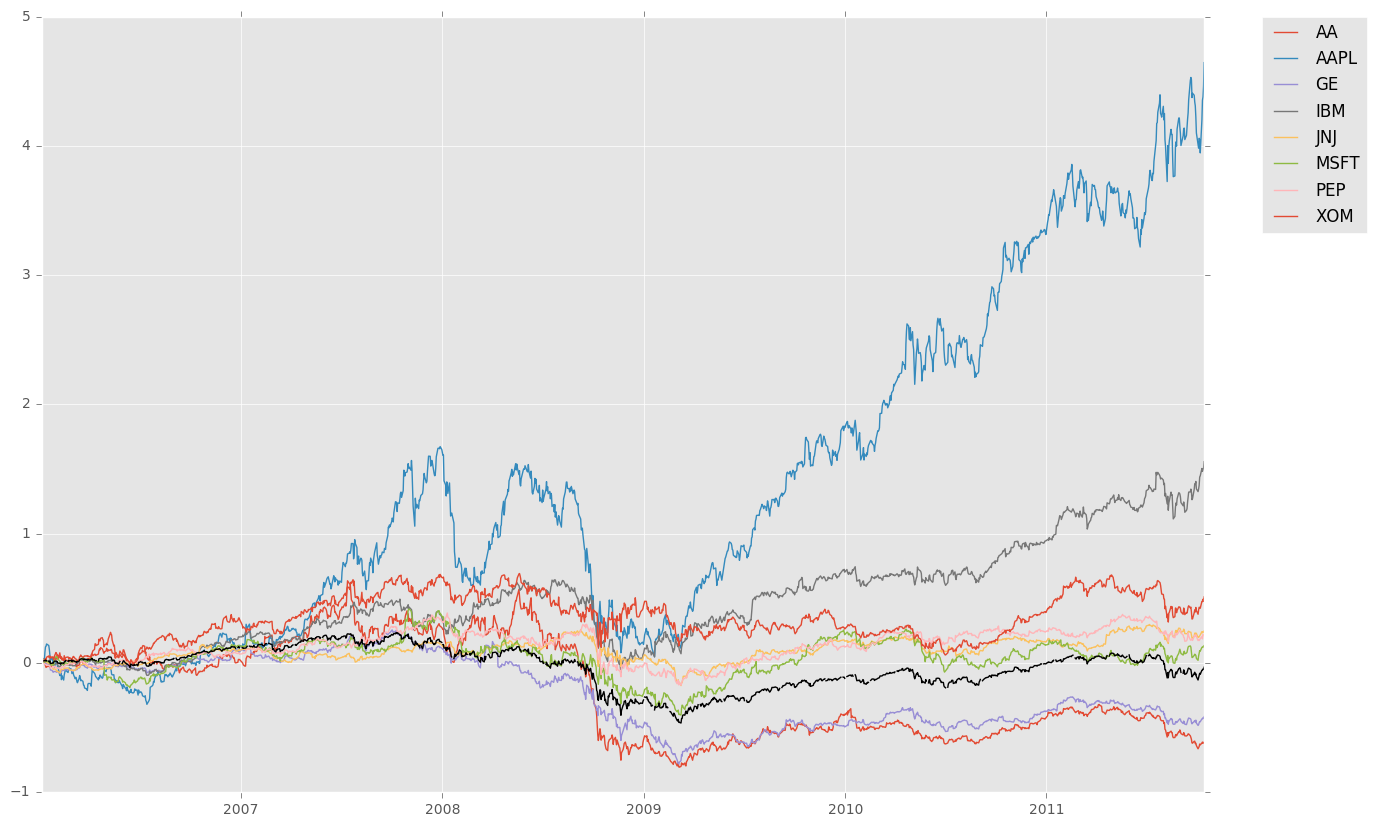

In [172]:
# stock closing between 2006 to 2011
stock_price2 = stock_price.ix['2006':'2011']

names = ['AA','AAPL','GE','IBM','JNJ','MSFT','PEP','XOM']
spy = ['SPX']

# Plot the cumulative return
rets = stock_price2[names].pct_change()
px1 = ((1 + rets).cumprod() - 1)
sp500 = stock_price2[spy].asfreq('B')
rets = sp500.pct_change()
px2 = ((1 + rets).cumprod() - 1)
plt.figure(figsize=(15, 10))
plt.style.use('ggplot')
plt.plot(px1)
plt.legend(px1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.plot(px2, color='k')

As can be seen from the chart most of these companies have better return than the S&P (SPX) index with the exception of IBM & Exon Mobile(XOM). Apple(APPL) has biggest gain since 2007 with few downard trend in between.

In [173]:
def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

The above function is used to see the momentum of the managed portfolio over a certain lookback time. This function ranks the stocks based on the momentum in a standardized way. With this rank we can calculate the risk and return on investing on similar stocks using Sharpe Ratio 

### Sharpe Ratio

This ratio is what gives us the summary of investment performance.In layman terms Zero risk gives zero return. Sharpe ratio represents the excess return the investor receives by investing on risker holding characterized by high volatility.

Sharpe Ratio = [R_p - R_f] / Sigma_p  
    
    Where:
        * R_p = Rate of return of portfolio
        * R_f = risk free Rate 
        * Sigma_p = Standard Deviation of the returns

Risk free investments are one like the US treasury that has the lowest possible volataility .
This formula gives the investor a risk adjusted return in comparison to a risk free investment by ensuring the investment scale is standardised by dividing the excess return by the standard deviation of the the risky asset being measured.

The caveat with this perfromance ratio is that it assumes the returns have a gaussian distribution. Sharpe ratio is robust to slight deviations in assumption but if the return distribution is highly skewed the ratio fails to be meaningfull.


In [174]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    # Compute portfolio returns
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [177]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(stock_price2, lb, hold)

ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [180]:
def heatmap(df, cmap=plt.cm.RdYlGn):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

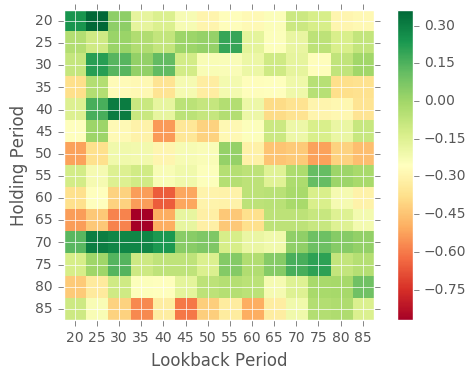

In [182]:
heatmap(ddf)

The above heatmap shows a grid of sharpe ratio against different holding back periods.  As can be seen from the heatmap the highest risk adjuted return is at holding period of 70 and lookback period of 25.

# Conclusion

In this case study we were able to reveal the internal structure of a time series data using Pandas timeseries analysis. Whether one is ineterested in forcasting or backtesting it is vital to understand the assumptions of handling a time series data i.e the time series data have zero mean and constant variance. Naturally most time series data are not stationary and by using the transformations such as differencing, decomposition and log or exponentiation we can bring the series to stationarity condition for further analysis.

ARIMA (Auto Regressive Integrated Moving Average) is commonly used time series model for forecasting the timeseries. By using PACF and ACF plots its possible to build a robust timeseries ARIMA model which can be used for prediction and forecasting in the future.

Signal Frontier Analysis has given us Sharpe Ratio to do comparisions of risk-return value. By learning the profile of the user i.e. whether the investor is risk averse or risk loving, it is easy to find from zero risk low return to high risk high return stocks. In addition if one has to backtest the stock price this methodology gives us the optimal window of time for holding and lockback to distinguish the best performing stock in the managed portfolio.

# References

An Introduction to Time Series Analysis and Forecasting with Applications of SAS and SPSS (Robert Yaffee and Monie McGee)

Box, G.E.P. and G.M. Jenkins (1976).  Time Series Analysis: Forecasting and Control. San Francisco: Holden-Day

Brockwell, P. J. and Davis, R. A. (1996). Introduction to Time Series and Forecasting. New York: Springer-Verlag

Chatfield, C. (1996). The Analysis of Time Series: An Introduction (5th edition). London:Chapman and Hall

Granger, C.W.J. and Paul Newbold 1986 Forecasting Economic Time Series. Orlando: Academic Press

McCleary, R. and R.A. Hay, Jr. (1980).  Applied Time Series Analysis for the Social Sciences.  Beverly Hills, Ca: Sage

Short-Term Forecasting with ARIMA Time Series Models. George E. P. 

https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
